In [1]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
from scipy import stats as st
import warnings
import statsmodels.api as sm
import pylab 
import datetime
import calendar
from datetime import datetime, timedelta

warnings.filterwarnings("ignore", category=FutureWarning)

In [2]:
df = pd.read_csv(r'E:\датасеты\customer_segmentation.csv')

In [3]:
df.sample(10)

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
284620,561879,21908,CHOCOLATE THIS WAY METAL SIGN,12,7/31/2011 12:43,2.10,13722.0,United Kingdom
349169,567482,21733,RED HANGING HEART T-LIGHT HOLDER,2,9/20/2011 13:42,2.95,16464.0,United Kingdom
484795,577542,35970,ZINC FOLKART SLEIGH BELLS,4,11/20/2011 14:33,1.69,13565.0,United Kingdom
511158,579472,22144,CHRISTMAS CRAFT LITTLE FRIENDS,1,11/29/2011 15:09,2.10,13521.0,United Kingdom
429602,573576,20723,STRAWBERRY CHARLOTTE BAG,4,10/31/2011 14:09,1.63,14096.0,United Kingdom
176818,552025,23204,CHARLOTTE BAG APPLES DESIGN,10,5/5/2011 18:04,0.85,13969.0,United Kingdom
269250,560444,22457,NATURAL SLATE HEART CHALKBOARD,3,7/18/2011 17:15,2.95,13764.0,United Kingdom
338750,566564,23205,CHARLOTTE BAG VINTAGE ALPHABET,3,9/13/2011 12:26,0.85,15522.0,United Kingdom
82869,543273,47420,ASSORTED COLOUR SUCTION CUP HOOK,2,2/6/2011 11:29,0.19,16456.0,United Kingdom
248747,558867,23240,SET OF 4 KNICK KNACK TINS DOILEY,6,7/4/2011 12:41,4.15,17765.0,United Kingdom


In [4]:
df.shape

(541909, 8)

In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 541909 entries, 0 to 541908
Data columns (total 8 columns):
 #   Column       Non-Null Count   Dtype  
---  ------       --------------   -----  
 0   InvoiceNo    541909 non-null  object 
 1   StockCode    541909 non-null  object 
 2   Description  540455 non-null  object 
 3   Quantity     541909 non-null  int64  
 4   InvoiceDate  541909 non-null  object 
 5   UnitPrice    541909 non-null  float64
 6   CustomerID   406829 non-null  float64
 7   Country      541909 non-null  object 
dtypes: float64(2), int64(1), object(5)
memory usage: 33.1+ MB


In [6]:
# посмотрим на пропуски в процентном соотношении по каждому столбцу
round(df.isnull().sum() / df.shape[0],3)

InvoiceNo      0.000
StockCode      0.000
Description    0.003
Quantity       0.000
InvoiceDate    0.000
UnitPrice      0.000
CustomerID     0.249
Country        0.000
dtype: float64

In [7]:
# посмотрим на дубликаты
df.duplicated().sum()

5268

In [8]:
# избавимся от дубликатов
df.drop_duplicates(inplace=True)

In [9]:
# избавимся от пропусков в айди пользователей
df = df[df['CustomerID'].notnull()]

In [10]:
#приводим даты к нужному типу
df['InvoiceDate'] =  df['InvoiceDate'].apply(lambda x:x.split(' ')[0])
df['InvoiceDate'] = pd.to_datetime(df['InvoiceDate'], format='%m/%d/%Y')

# расчитываем выручку
df['revenue'] = df['UnitPrice'] * df['Quantity']

In [11]:
# избавились от нулей в айдишниках
df['CustomerID'] = df['CustomerID'].astype('str')
df['CustomerID'] =  df['CustomerID'].apply(lambda x:x.split('.')[0])

In [12]:
# сортируем для когортного анализа
df.sort_values(by=['CustomerID','InvoiceDate'],inplace=True)


In [13]:
# смотриим на перцентили в количестве покупок в чеке, чтобы избавиться от аномалий
print(np.percentile(df['Quantity'],99))
print(np.percentile(df['Quantity'],1))

120.0
-2.0


In [14]:
# переписываем датафрейм с фильтрами по перцентилям
df = df[(df['Quantity'] < 200) & (df['Quantity'] > 0)]

In [15]:
# посмотрим на перцентили еще раз
print(np.percentile(df['UnitPrice'],99))
print(np.percentile(df['UnitPrice'],1))

14.95
0.21


In [16]:
df['InvoiceDate'] = pd.to_datetime(df['InvoiceDate'])
df['InvoiceMonth'] = df['InvoiceDate'].apply(lambda x : x.replace(day=1))

In [17]:
#берем минимальную дату покупки по каждому клиенту, чтобы в дальнейшем вычесть дату покупки от мин даты
date = df.groupby('CustomerID').agg({'InvoiceMonth':'min'}).reset_index().rename(columns={'InvoiceMonth':'month'})

# джойним таблицы
df = df.merge(date,on='CustomerID',how='left')

In [18]:
df.sample(5)

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country,revenue,InvoiceMonth,month
71178,573385,35954,SMALL FOLKART STAR CHRISTMAS DEC,48,2011-10-30,0.19,13421,United Kingdom,9.12,2011-10-01,2011-02-01
17863,547492,21122,SET/10 PINK POLKADOT PARTY CANDLES,24,2011-03-23,1.25,12604,France,30.00,2011-03-01,2011-03-01
132524,560864,85130D,BEADED CRYSTAL HEART PINK LARGE,24,2011-07-21,0.79,14407,United Kingdom,18.96,2011-07-01,2011-03-01
279779,555949,85099B,JUMBO BAG RED RETROSPOT,10,2011-06-08,2.08,16626,United Kingdom,20.80,2011-06-01,2011-03-01
334320,573026,22586,FELTCRAFT HAIRBAND PINK AND BLUE,12,2011-10-27,0.85,17459,United Kingdom,10.20,2011-10-01,2011-10-01


In [19]:
df['days_lifetime'] = (df['InvoiceDate'] - df['month']).dt.days
df['month_lifetime'] = np.floor(df['days_lifetime'] / 30)

In [20]:
df.sample(5)

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country,revenue,InvoiceMonth,month,days_lifetime,month_lifetime
214432,541684,22115,METAL SIGN EMPIRE TEA,5,2011-01-20,2.95,15498,United Kingdom,14.75,2011-01-01,2010-12-01,50,1.0
87046,553675,21718,RED METAL BEACH SPADE,12,2011-05-18,1.25,13719,United Kingdom,15.00,2011-05-01,2011-04-01,47,1.0
151293,563328,22170,PICTURE FRAME WOOD TRIPLE PORTRAIT,1,2011-08-15,6.75,14606,United Kingdom,6.75,2011-08-01,2010-12-01,257,8.0
326165,549578,21870,I CAN ONLY PLEASE ONE PERSON MUG,12,2011-04-11,1.25,17340,United Kingdom,15.00,2011-04-01,2010-12-01,131,4.0
317922,538382,22568,FELTCRAFT CUSHION OWL,3,2010-12-12,3.75,17218,United Kingdom,11.25,2010-12-01,2010-12-01,11,0.0


In [21]:
result_cohort = df.pivot_table(index='month',columns='month_lifetime',values='CustomerID',aggfunc='nunique')
result_cohort

month_lifetime,0.0,1.0,2.0,3.0,4.0,5.0,6.0,7.0,8.0,9.0,10.0,11.0,12.0
month,,,,,,,,,,,,,
2010-12-01,877.0,301.0,304.0,324.0,327.0,343.0,307.0,310.0,302.0,325.0,327.0,441.0,303.0
2011-01-01,395.0,111.0,110.0,95.0,131.0,116.0,105.0,99.0,116.0,136.0,151.0,76.0,NaN
2011-02-01,375.0,73.0,67.0,101.0,100.0,90.0,90.0,95.0,99.0,111.0,43.0,NaN,NaN
2011-03-01,432.0,84.0,108.0,88.0,98.0,77.0,107.0,104.0,126.0,54.0,NaN,NaN,NaN
2011-04-01,300.0,62.0,63.0,64.0,56.0,59.0,66.0,76.0,32.0,NaN,NaN,NaN,NaN
2011-05-01,270.0,63.0,49.0,47.0,50.0,75.0,70.0,39.0,NaN,NaN,NaN,NaN,NaN
2011-06-01,241.0,39.0,40.0,57.0,55.0,79.0,34.0,NaN,NaN,NaN,NaN,NaN,NaN
2011-07-01,184.0,39.0,37.0,45.0,47.0,28.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2011-08-01,164.0,38.0,37.0,44.0,24.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [22]:
# считаем кол-во людей в когортах
cohort_sizes = (
    df.groupby('month')
    .agg({'CustomerID': 'nunique'})
    .rename(columns={'CustomerID': 'cohort_size'})
)

In [23]:
# джойним таблицы
result_grouped = cohort_sizes.merge(
    result_cohort, on='month', how='left'
).fillna(0)


In [24]:
# делим данные на кол-во людей в когорте
result_grouped = result_grouped.div(
    result_grouped['cohort_size'], axis=0
).drop(columns=['cohort_size',0])

result_grouped

,1.0,2.0,3.0,4.0,5.0,6.0,7.0,8.0,9.0,10.0,11.0,12.0
month,,,,,,,,,,,,
2010-12-01,0.343216,0.346636,0.369441,0.372862,0.391106,0.350057,0.353478,0.344356,0.370582,0.372862,0.502851,0.345496
2011-01-01,0.268116,0.265700,0.229469,0.316425,0.280193,0.253623,0.239130,0.280193,0.328502,0.364734,0.183575,0.000000
2011-02-01,0.194667,0.178667,0.269333,0.266667,0.240000,0.240000,0.253333,0.264000,0.296000,0.114667,0.000000,0.000000
2011-03-01,0.186253,0.239468,0.195122,0.217295,0.170732,0.237251,0.230599,0.279379,0.119734,0.000000,0.000000,0.000000
2011-04-01,0.206667,0.210000,0.213333,0.186667,0.196667,0.220000,0.253333,0.106667,0.000000,0.000000,0.000000,0.000000
2011-05-01,0.225000,0.175000,0.167857,0.178571,0.267857,0.250000,0.139286,0.000000,0.000000,0.000000,0.000000,0.000000
2011-06-01,0.161826,0.165975,0.236515,0.228216,0.327801,0.141079,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
2011-07-01,0.206349,0.195767,0.238095,0.248677,0.148148,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
2011-08-01,0.224852,0.218935,0.260355,0.142012,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000


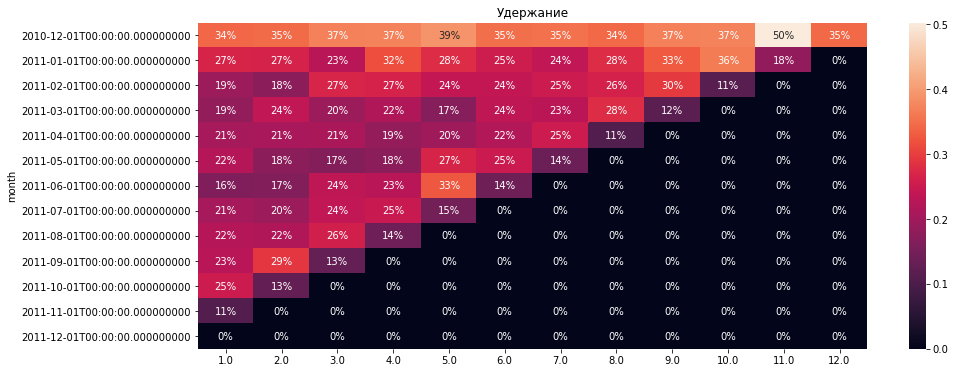

In [25]:
# Строим тепловую карту удержания

plt.figure(figsize=(15, 6))  # задаём размер графика
sns.heatmap(
    result_grouped, 
    annot=True,  # включаем подписи
    fmt='.0%',  # переводим значения в проценты
)

plt.title('Удержание')  # название графика
plt.show()

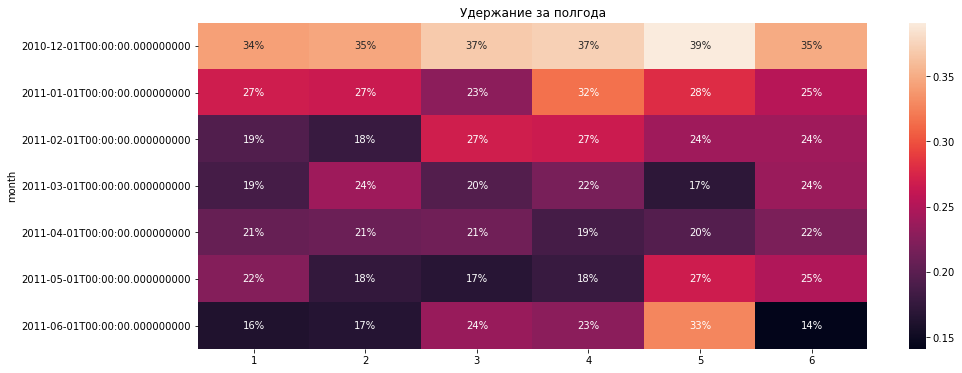

In [26]:
plt.figure(figsize=(15, 6))  # задаём размер графика
sns.heatmap(
    result_grouped.loc[:,list(range(1,7))].head(7), 
    annot=True,  # включаем подписи
    fmt='.0%',  # переводим значения в проценты
)

plt.title('Удержание за полгода')  # название графика
plt.show()

Видим, что наибольший возврат пользователей приходится на первую когорту, которая приходится на 1 и 2 когорты

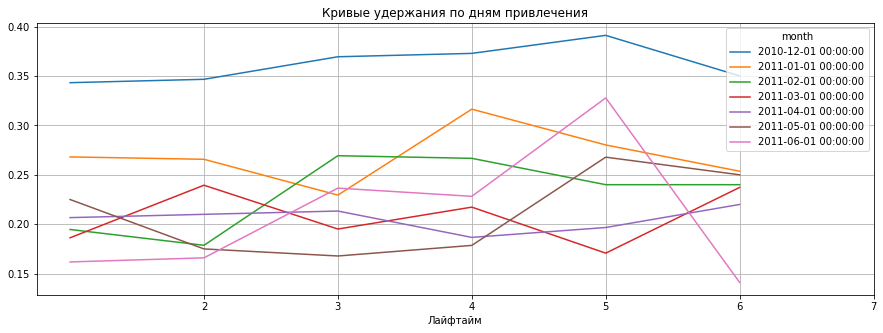

In [27]:
result_grouped.loc[:,list(range(1,7))].head(7).T.plot(
    grid=True,  # добавляем сетку
    xticks=list(result_grouped.columns.values[1:7]),  # отметки на оси X — названия колонок
    figsize=(15, 5),  # размер графика
)
plt.xlabel('Лайфтайм')  # название оси X
plt.title('Кривые удержания по дням привлечения')  # название графика
plt.show()

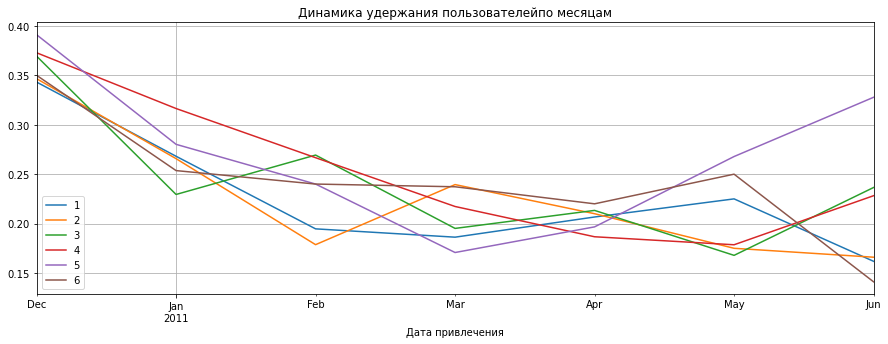

In [28]:
result_grouped.loc[:,list(range(1,7))].head(7).plot(grid=True, figsize=(15, 5))
plt.xlabel('Дата привлечения')
plt.title('Динамика удержания пользователейпо месяцам')
plt.show()

In [29]:
# расчитываем LTV
ltv = df.pivot_table(index=[],columns='month_lifetime',values='revenue',aggfunc='sum')
ltv = ltv.fillna(0).cumsum(axis=1)  
ltv

month_lifetime,0.0,1.0,2.0,3.0,4.0,5.0,6.0,7.0,8.0,9.0,10.0,11.0,12.0
revenue,1986661.663,2506056.223,3007917.793,3532362.453,3997015.613,4539203.043,4986141.233,5465145.153,5907338.394,6393881.314,6857977.584,7343716.454,7561407.734


In [30]:
cohort_sizes = cohort_sizes.cumsum().tail(1)
cohort_sizes.index = ['revenue']

ltv = pd.merge(cohort_sizes, ltv, left_index=True, right_index=True)


In [31]:
# делим общуя куммулятивную выручку на кол-во клиентов
ltv = ltv.div(ltv['cohort_size'],axis=0).drop(columns='cohort_size')

In [37]:
# берем только 6 месяцев
half_year = ltv[list(range(7))]

In [44]:
half_year

,0.0,1.0,2.0,3.0,4.0,5.0,6.0
revenue,460.728586,581.18187,697.569061,819.193519,926.951673,1052.690873,1156.340731


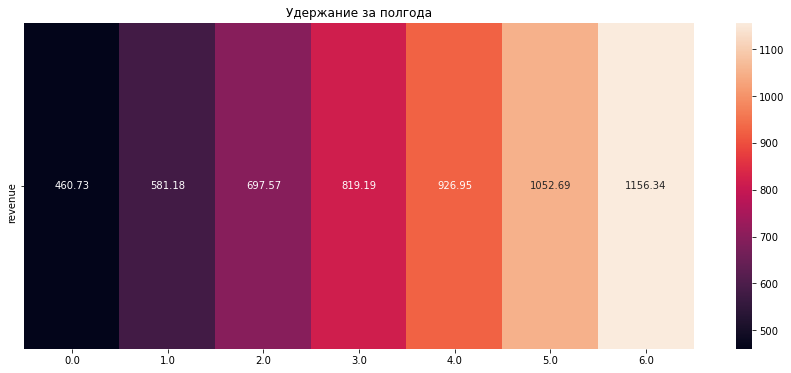

In [48]:
plt.figure(figsize=(15, 6))  # задаём размер графика
sns.heatmap(
    half_year, 
    annot=True,
    fmt ='.2f'
)

plt.title('LTV за полгода')  # название графика
plt.show()

<AxesSubplot:>

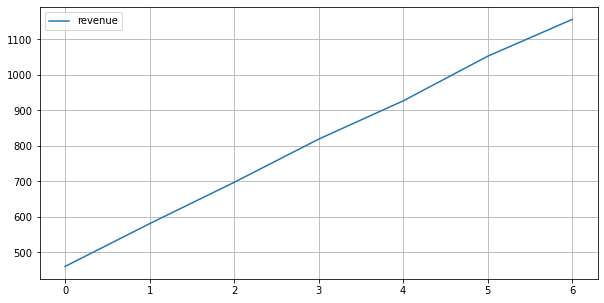

In [49]:
# график LTV за полгода
half_year
half_year.T.plot(grid=True, figsize=(10, 5), xticks=list(report.columns.values))